In [1]:

import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import math

In [3]:
data = pd.read_csv("song_data.csv")
data.head(10)


,user_id,song_id,listen_count,title,artist,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,The Cove - Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Kanye West,Stronger - Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson,Constellations - Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock \'N\' Roll,Héroes del Silencio,Apuesta Por El Rock \'N\' Roll - Héroes del Si...
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,Paper Gangsta,Lady GaGa,Paper Gangsta - Lady GaGa
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1,Stacked Actors,Foo Fighters,Stacked Actors - Foo Fighters
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,Sehr kosmisch,Harmonia,Sehr kosmisch - Harmonia
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1,Heaven\'s gonna burn your eyes,Thievery Corporation feat. Emiliana Torrini,Heaven\'s gonna burn your eyes - Thievery Corp...


In [4]:
le_users = LabelEncoder()
le_contents = LabelEncoder()

le3 = LabelEncoder()
data["le_title"] = le3.fit_transform(data["title"])

data["le_user"] = le_users.fit_transform(data["user_id"])
data["le_content"] = le_contents.fit_transform(data["song_id"])

In [5]:
epochs = 0
count = 0
def create_batch(batch_size):
    global epochs
    global count
    start = count
    end = count + batch_size - 1
    count = count + batch_size
    if count >= len(data):
        end = len(data)
        count = 0
        epochs+=1
    users = data["le_user"].loc[start:end]
    contents = data["le_content"].loc[start:end]
    return users,contents

In [6]:
num_users = max(data["le_user"]) + 1
num_content = max(data["le_content"]) + 1

In [16]:
embedding_size = 50
user_input = tf.placeholder(tf.int32, shape = [None])
content_input = tf.placeholder(tf.int32, shape = [None,])
lr = tf.placeholder(tf.float32)
all_user_embedding = tf.Variable(tf.random_uniform([num_users,embedding_size], -1.0,1.0))
all_content_embedding = tf.Variable(tf.truncated_normal(shape=[num_content,embedding_size], stddev=1/math.sqrt(embedding_size)))
all_user_embedding

<tf.Variable 'Variable_8:0' shape=(66346, 50) dtype=float32_ref>

In [14]:
user_embed = tf.nn.embedding_lookup(all_user_embedding,user_input)
content_embed = tf.nn.embedding_lookup(all_content_embedding,content_input)



<tf.Tensor 'embedding_lookup_2/Identity:0' shape=(?, 50) dtype=float32>

In [12]:
user_to_content_weigths = tf.Variable(tf.truncated_normal([50,50], stddev = math.sqrt(1.0/50)))
user_to_content_biases = tf.Variable(tf.zeros([50]))
content_to_user_biases = tf.Variable(tf.zeros([50]))



<tf.Variable 'Variable_7:0' shape=(50,) dtype=float32_ref>

In [10]:
content_from_user = tf.add(tf.matmul(user_embed, user_to_content_weigths), user_to_content_biases)
user_from_content = tf.add(tf.matmul(content_embed, tf.transpose(user_to_content_weigths)), content_to_user_biases)

In [15]:
forward_loss = tf.losses.mean_squared_error(content_embed,content_from_user)
backward_loss = tf.losses.mean_squared_error(user_embed, user_from_content)

forward_optimize = tf.train.AdamOptimizer().minimize(forward_loss)
backward_optimize = tf.train.AdamOptimizer().minimize(backward_loss)

content_embed, content_from_user

(<tf.Tensor 'embedding_lookup_3/Identity:0' shape=(?, 50) dtype=float32>,
 <tf.Tensor 'Add:0' shape=(?, 50) dtype=float32>)

In [28]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

sess.run(forward_loss, feed_dict = {user_input:[max(data["le_user"])], content_input:[max(data["le_content"])]})

0.36117214

In [12]:
0.01*(0.92**50)

0.00015466475831843503

In [13]:
0.007*(0.95**50)

0.0005386148269369921

In [29]:
learning_rate = 0.007
batch_size = 1200
f_losses = []
b_losses = []
l_rates = []
for i in range(1001):
    user_batch, content_batch = create_batch(batch_size)
    f_loss, b_loss, _f, _b = sess.run([forward_loss, backward_loss, forward_optimize, backward_optimize],
                                      feed_dict = {user_input:user_batch, content_input:content_batch, lr:learning_rate})
    if i % 200 == 0:
        print ("epoch -",epochs,"--","forward loss =", np.mean(f_loss),"\t backward loss =", np.mean(b_loss),"\t at iter", i,"\t learning rate",learning_rate)
        f_losses.append(np.mean(f_loss))
        b_losses.append(np.mean(b_loss))
        l_rates.append(learning_rate)
        learning_rate = learning_rate*0.94

epoch - 2 -- forward loss = 0.27543274 	 backward loss = 0.34340185 	 at iter 0 	 learning rate 0.007
epoch - 2 -- forward loss = 0.0579599 	 backward loss = 0.34051764 	 at iter 200 	 learning rate 0.00658
epoch - 2 -- forward loss = 0.021676132 	 backward loss = 0.32909596 	 at iter 400 	 learning rate 0.006185199999999999
epoch - 2 -- forward loss = 0.015611042 	 backward loss = 0.31979492 	 at iter 600 	 learning rate 0.0058140879999999985
epoch - 3 -- forward loss = 0.014531244 	 backward loss = 0.33153227 	 at iter 800 	 learning rate 0.005465242719999998
epoch - 3 -- forward loss = 0.014491856 	 backward loss = 0.323401 	 at iter 1000 	 learning rate 0.005137328156799998


In [29]:
num_content

10000

In [13]:
def recommend_content_for_user( userID):
    content_probs = sess.run(content_from_hidden_rep, feed_dict = {user_input:[userID]})
    contents = np.argsort(content_probs[0])
    return contents

def recommend_users_for_content(contentID):
    user_probs = sess.run(user_from_hidden_rep, feed_dict = {content_input:[contentID]})
    users = np.argsort(user_probs[0])
    return users

In [14]:
def get_similar_users(userID):
    hidden_rep = sess.run(hidden_rep_from_user, feed_dict = {user_input:[userID]})
    user_prob = sess.run(user_from_hidden_rep, feed_dict = {hidden_rep_from_content:hidden_rep})
    similar_users = np.argsort(user_prob[0])
    return similar_users

def get_similar_contents(contentID):
    hidden_rep = sess.run(hidden_rep_from_content, feed_dict = {content_input:[contentID]})
    content_probs = sess.run(content_from_hidden_rep, feed_dict = {hidden_rep_from_user:hidden_rep})
    similar_contents = np.argsort(content_probs[0])
    return similar_contents

In [17]:
import ipywidgets as widgets
print(widgets.Button.on_click.__doc__)

Register a callback to execute when the button is clicked.

        The callback will be called with one argument, the clicked button
        widget instance.

        Parameters
        ----------
        remove: bool (optional)
            Set to true to remove the callback from the list of callbacks.
        


In [18]:
from IPython.display import display
button = widgets.Button(description="Click Me!")
display(button)

def on_button_clicked(b):
    print("anuj")

button.on_click(on_button_clicked)

Button(description='Click Me!', style=ButtonStyle())

In [19]:
b = np.random.randint(1,200,5)
list(data["title"].loc[b].values)

['Swimming In The Flood',
 "Ain\\'t No Rest For The Wicked (Original Version)",
 'Just Lose It',
 'Belle',
 'Cry For Help (Album Version)']

In [8]:
def random_songs():
    a = list(np.random.randint(1,200,10))
    return list(data["title"].loc[a])

In [21]:
from ipywidgets import ToggleButtons

a = ToggleButtons(options = random_songs())
a

ToggleButtons(options=('Who Knows Who Cares', "He Doesn\\'t Know Why", "Ain\\'t Misbehavin", 'Revelry', 'The B…

In [138]:
def get_row(loc):
    return data.loc[loc:loc+5][["title","artist"]]

def get_val(a_val):
    this_val = a_val["new"]
    print(get_row(int(this_val)))

In [139]:
a.observe(get_val, "value")

In [22]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
text = widgets.Text()
display(text)

def handle_submit(sender):
    clear_output()
    display(text)
    print (data.loc[int(text.value)])
    
text.on_submit(handle_submit)

Text(value='')

In [41]:
import ipywidgets as widgets
from IPython.display import display, Markdown
from IPython.display import clear_output
text2 = widgets.Text()
display(text2)

def print_contents(df):
    uniques = df["title"].unique()
    new_df = df[["title","artist"]]
    display(new_df.drop_duplicates())


def similar_content(sender):
    clear_output()
    display(text2)
    #title_id = le3.inverse_transform(int(text2.value))
    title_id = text2.value
    artist = data[data["title"] == title_id]["artist"].iloc[0]
    s = "showing similar items to title - "+ title_id+ " by artist "+artist
    print('\x1b[1;31m'+s+'\x1b[0m')
    print("-----------------------------------------------------------------")
    content_id = data[data["title"] == title_id]["le_content"].iloc[0]
    similar_c = get_similar_contents(content_id)[-10:-1]
    similar_ti = data[data["le_content"].isin(similar_c)]
    print_contents(similar_ti)
    
text2.on_submit(similar_content)

Text(value='')

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
data

,user_id,song_id,listen_count,title,artist,song,le_user,le_content
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,The Cove - Jack Johnson,47729,153
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia,47729,413
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Kanye West,Stronger - Kanye West,47729,736
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson,Constellations - Jack Johnson,47729,750
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters,47729,1188
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock \'N\' Roll,Héroes del Silencio,Apuesta Por El Rock \'N\' Roll - Héroes del Si...,47729,1239
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,Paper Gangsta,Lady GaGa,Paper Gangsta - Lady GaGa,47729,1536
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1,Stacked Actors,Foo Fighters,Stacked Actors - Foo Fighters,47729,2056
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,Sehr kosmisch,Harmonia,Sehr kosmisch - Harmonia,47729,2220
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1,Heaven\'s gonna burn your eyes,Thievery Corporation feat. Emiliana Torrini,Heaven\'s gonna burn your eyes - Thievery Corp...,47729,3046


In [23]:
sc = get_similar_contents(736)
sc[-30:]

array([ 337, 6079, 8092, 7333, 6061, 8772, 4441, 9852, 2720, 5746, 9297,
       9434, 7756, 1580, 9391, 3769, 5565,  907,  984, 7871, 4932, 1261,
       5725, 1590, 4414, 3108, 1825, 2535, 3558,  736], dtype=int64)

In [24]:
data[data["le_content"].isin(sc[-4:-1])]#.groupby("artist").count()

,user_id,song_id,listen_count,title,artist,song,le_user,le_content
5770,e8612acfb1572297ea0eaaa1f27927d55fdcec65,SOIYWPZ12A81C204EF,2,Homecoming,Kanye West,Homecoming - Kanye West,60146,3558
9013,7b544bb0c02878033e4e4eea4df0a10466a71405,SOGKAYF12A81C204CD,1,Good Life,Kanye West / T-Pain,Good Life - Kanye West / T-Pain,31854,2535
11729,6279734d7e01ab803a6c5d1a49c9b902d2c554f1,SOGKAYF12A81C204CD,2,Good Life,Kanye West / T-Pain,Good Life - Kanye West / T-Pain,25487,2535
11735,6279734d7e01ab803a6c5d1a49c9b902d2c554f1,SOIYWPZ12A81C204EF,1,Homecoming,Kanye West,Homecoming - Kanye West,25487,3558
17370,65014d7a44af245dc85801c64bbeecbbcdefa701,SOIYWPZ12A81C204EF,4,Homecoming,Kanye West,Homecoming - Kanye West,26074,3558
17643,fd7b78f7c22a39b64bbb9e49cee0ffe2dac5b849,SOGKAYF12A81C204CD,1,Good Life,Kanye West / T-Pain,Good Life - Kanye West / T-Pain,65704,2535
17645,fd7b78f7c22a39b64bbb9e49cee0ffe2dac5b849,SOIYWPZ12A81C204EF,8,Homecoming,Kanye West,Homecoming - Kanye West,65704,3558
17977,57bfad86d580ac12fd6b3607ac6098623ec40002,SOIYWPZ12A81C204EF,2,Homecoming,Kanye West,Homecoming - Kanye West,22747,3558
18455,3c72bafd3c3112f29e99273b5c44de2e76c65861,SOGKAYF12A81C204CD,1,Good Life,Kanye West / T-Pain,Good Life - Kanye West / T-Pain,15673,2535
18457,3c72bafd3c3112f29e99273b5c44de2e76c65861,SOIYWPZ12A81C204EF,1,Homecoming,Kanye West,Homecoming - Kanye West,15673,3558


In [43]:
data[data["le_content"].isin(sc[-10:-1])]

,user_id,song_id,listen_count,title,artist,song,le_user,le_content
2072,dfb41c400ed8fbb064644d173f8fd00398ca4370,SOXBPBX12AB0183CD1,6,Nothing Even Matters,Lauryn Hill Featuring D\'Angelo,Nothing Even Matters - Lauryn Hill Featuring D...,57865,8957
4783,1b96dd04ce96aa7995e0f817e762ca44a24aab24,SORHLQN12A6701FC3E,2,Danger,Erykah Badu,Danger - Erykah Badu,7042,6827
4785,1b96dd04ce96aa7995e0f817e762ca44a24aab24,SOSDBDE12A6D4F9CFB,1,Girl Next Door,Musiq / Ayana,Girl Next Door - Musiq / Ayana,7042,7111
4942,3e85485842091c62ad86fa31f1e35799df1cf0c4,SOXBPBX12AB0183CD1,14,Nothing Even Matters,Lauryn Hill Featuring D\'Angelo,Nothing Even Matters - Lauryn Hill Featuring D...,16201,8957
5835,c3953e49b785c940f53a556abd9ca681c5ef48c5,SOXBPBX12AB0183CD1,2,Nothing Even Matters,Lauryn Hill Featuring D\'Angelo,Nothing Even Matters - Lauryn Hill Featuring D...,50653,8957
7431,4926960fa1f2aa9f6c46bf591e83bb4e3d7f6a6f,SODPGZQ12A58A79D74,1,Dontchange,Musiq,Dontchange - Musiq,18922,1412
10413,bdc7c976ce178aa4e75bbf9874fdaf327f3d3fe2,SOTLDCX12AAF3B1356,1,We\'re Not Making Love No More,Dru Hill,We\'re Not Making Love No More - Dru Hill,49214,7640
18096,e7939b65da3282b2552617dcef34d11a93744df9,SOTLDCX12AAF3B1356,1,We\'re Not Making Love No More,Dru Hill,We\'re Not Making Love No More - Dru Hill,59937,7640
23567,74d0c24a0bb5bde014ffbf57fc5c51b9b5b799a0,SOPKFQB12A67ADBAD6,3,Teach U a Lesson,Robin Thicke,Teach U a Lesson - Robin Thicke,30124,6085
24491,e9ba347d6bcf96d76cdc4338f7202d73ee94eaf2,SOXBPBX12AB0183CD1,3,Nothing Even Matters,Lauryn Hill Featuring D\'Angelo,Nothing Even Matters - Lauryn Hill Featuring D...,60493,8957


In [45]:
grp = data.groupby("artist")['title'].nunique().sort_values( ascending = False)#(by = "title", ascending = False)
grp

artist
The Black Keys                                             71
Daft Punk                                                  58
Coldplay                                                   58
Radiohead                                                  52
Jack Johnson                                               51
Muse                                                       49
The New Pornographers                                      48
Camera Obscura                                             42
Gorillaz                                                   41
The Killers                                                40
Metallica                                                  40
The Decemberists                                           39
Hot Chip                                                   37
Rammstein                                                  35
Rise Against                                               35
Red Hot Chili Peppers                                      35
F

In [46]:
grp.iloc[200:230]

artist
Elliott Smith           11
Chromeo                 11
The Strokes             11
Deftones                11
Phil Collins            10
Andres Calamaro         10
Tom Petty               10
Charly García           10
Eddie Vedder            10
Panic At The Disco      10
The Raconteurs          10
Camila                  10
Dido                    10
Godsmack                10
Wilco                   10
Caribou                 10
Jorge Drexler           10
Carla Bruni             10
ATB                     10
Zero 7                  10
Marc Anthony            10
Marilyn Manson          10
Corinne Bailey Rae      10
Bersuit Vergarabat      10
Max Richter             10
The Lonely Island       10
Bebe                    10
Michael Jackson         10
Jane\'s Addiction       10
Two Door Cinema Club    10
Name: title, dtype: int64

In [39]:
data[data["artist"] == "Musiq"]

,user_id,song_id,listen_count,title,artist,song,le_user,le_content
4761,1b96dd04ce96aa7995e0f817e762ca44a24aab24,SOBHBKJ12A6D4F9D00,1,Love,Musiq,Love - Musiq,7042,492
4764,1b96dd04ce96aa7995e0f817e762ca44a24aab24,SODOPBE12A6D4F8976,1,Romancipation,Musiq,Romancipation - Musiq,7042,1398
4768,1b96dd04ce96aa7995e0f817e762ca44a24aab24,SOHNJHW12AB017F82A,1,Womanopoly,Musiq,Womanopoly - Musiq,7042,2984
4784,1b96dd04ce96aa7995e0f817e762ca44a24aab24,SORRFGI12A6D4F9CFF,2,143,Musiq,143 - Musiq,7042,6966
4793,1b96dd04ce96aa7995e0f817e762ca44a24aab24,SOXXUSA12A6D4F896E,2,Infatueighties,Musiq,Infatueighties - Musiq,7042,9270
7428,4926960fa1f2aa9f6c46bf591e83bb4e3d7f6a6f,SOBHBKJ12A6D4F9D00,1,Love,Musiq,Love - Musiq,18922,492
7431,4926960fa1f2aa9f6c46bf591e83bb4e3d7f6a6f,SODPGZQ12A58A79D74,1,Dontchange,Musiq,Dontchange - Musiq,18922,1412
14343,cb72016a84e34c3657d30dd97a95bfb7f9b8d1fe,SOXXUSA12A6D4F896E,1,Infatueighties,Musiq,Infatueighties - Musiq,52645,9270
18075,e7939b65da3282b2552617dcef34d11a93744df9,SOBHBKJ12A6D4F9D00,1,Love,Musiq,Love - Musiq,59937,492
29576,15ffdcc4da6e07c58f58b3c3f91fa704cafdd3c3,SORRFGI12A6D4F9CFF,1,143,Musiq,143 - Musiq,5671,6966


In [58]:
data

,user_id,song_id,listen_count,title,artist,song,le_user,le_content
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,The Cove - Jack Johnson,47729,153
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia,47729,413
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Kanye West,Stronger - Kanye West,47729,736
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson,Constellations - Jack Johnson,47729,750
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters,47729,1188
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock \'N\' Roll,Héroes del Silencio,Apuesta Por El Rock \'N\' Roll - Héroes del Si...,47729,1239
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,Paper Gangsta,Lady GaGa,Paper Gangsta - Lady GaGa,47729,1536
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1,Stacked Actors,Foo Fighters,Stacked Actors - Foo Fighters,47729,2056
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,Sehr kosmisch,Harmonia,Sehr kosmisch - Harmonia,47729,2220
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1,Heaven\'s gonna burn your eyes,Thievery Corporation feat. Emiliana Torrini,Heaven\'s gonna burn your eyes - Thievery Corp...,47729,3046


In [25]:
u = 47729
b = get_similar_users(u)
b[-20:]

array([10972, 48076, 55978, 38230, 23164, 33060,  5194, 42618, 41769,
       51479, 12325, 53950, 23697, 42569, 42241,  4839, 12275,  1136,
       47729, 47093], dtype=int64)

In [60]:
u = 47729
b = get_similar_users(u)
b[-20:]

array([47893, 59142, 58891, 14329, 32676,  5277,  2965, 39875, 59160,
       11111, 42415, 16484, 66302, 47529, 57876, 15201, 36929, 45967,
       21040, 47729], dtype=int64)

In [26]:
this_user = data[data["le_user"] == u]
grpu = this_user.groupby("artist").count().sort_values(by = "title", ascending = False)
grpu

,user_id,song_id,listen_count,title,song,le_user,le_content
artist,,,,,,,
John Mayer,6,6,6,6,6,6,6
Fleet Foxes,4,4,4,4,4,4,4
Foo Fighters,4,4,4,4,4,4,4
Jack Johnson,4,4,4,4,4,4,4
Incubus,3,3,3,3,3,3,3
Kanye West,2,2,2,2,2,2,2
Lady GaGa,1,1,1,1,1,1,1
Thievery Corporation,1,1,1,1,1,1,1
The String Cheese Incident,1,1,1,1,1,1,1


In [28]:
next_user = data[data["le_user"].isin(b[-10:-1])]
grpu = next_user.groupby("artist").count().sort_values(by = "title", ascending = False)
grpu

,user_id,song_id,listen_count,title,song,le_user,le_content
artist,,,,,,,
Postal Service,9,9,9,9,9,9,9
Justin Bieber,9,9,9,9,9,9,9
The Killers,8,8,8,8,8,8,8
All Time Low,7,7,7,7,7,7,7
Lily Allen,4,4,4,4,4,4,4
John Mayer,3,3,3,3,3,3,3
Buju Banton,3,3,3,3,3,3,3
tobyMac,2,2,2,2,2,2,2
Green Day,2,2,2,2,2,2,2


In [56]:
epochs

10

In [50]:
artists = ["Justin Bieber","Ke$ha","The Killers"]
c = data[data["artist"].isin(artists)]["le_content"].values
em = get_embed_for_contents(c)
em.shape

(15793, 100)

In [51]:
def get_embed_for_contents(contents):
    embeds = sess.run(hidden_rep_from_content, feed_dict = {content_input:contents})
    return embeds

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

In [53]:
pca_embed = pca.fit_transform(em)

In [54]:
import matplotlib.pyplot as plt

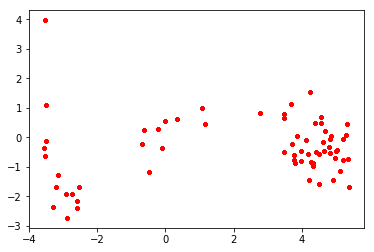

In [55]:
plt.plot(pca_embed[:,0],pca_embed[:,1], "r.")
plt.show()

In [57]:
pca_embed[:,0].shape

(5797,)

In [37]:
pca_embed

array([[ 3.3424165 ,  1.1211941 ],
       [ 3.3424172 ,  1.1212119 ],
       [ 3.342418  ,  1.1212028 ],
       ...,
       [-1.6198088 , -0.37762788],
       [ 3.3424184 ,  1.1212026 ],
       [ 3.342418  ,  1.1212027 ]], dtype=float32)

In [33]:
data.sample(10)[["artist","title","le_title"]]

,artist,title,le_title
690902,Donna Lewis,I Love You Always Forever ( LP Version ),3635
155325,Britney Spears,Toxic,8570
802088,Local Natives,Camera Talk,1231
473108,Lipps Inc.,Funkytown,2767
868170,John Waite,Missing You,5171
145532,Akon,Be With You,724
151128,Kings Of Leon,Be Somebody,722
993531,The Killers,This Is Your Life,8389
562203,Shakira,Loba,4690
305370,Steely Dan,My Old School,5396


In [42]:
display(text2)
text2.on_submit(similar_content)

Text(value='Be Somebody')

showing similar items to title - Be Somebody by artist Kings Of Leon
-----------------------------------------------------------------


,title,artist
91,You\'re The One,Dwight Yoakam
94,Hey_ Soul Sister,Train
95,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
105,Revelry,Kings Of Leon
106,Marry Me,Train
111,Use Somebody,Kings Of Leon
170,Electric Feel,MGMT
961,Sincerité Et Jalousie,Alliance Ethnik
4962,Be Somebody,Kings Of Leon
